<a href="https://colab.research.google.com/github/Amogh-Walia/DCGAN/blob/main/DCGAN_ON_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MAKE SURE THAT THE HARDWARE ACCELERATOR IS SET AS TPU


In [3]:
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

Installing TPU compatible PyTorch versions

In [1]:
!pip install cloud-tpu-client==0.10 torch==1.11.0 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-1.11-cp37-cp37m-linux_x86_64.whl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 152.9 MB 39 kB/s 
     |████████████████████████████████| 57 kB 2.6 MB/s 
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 1.12.11
    Uninstalling google-api-python-client-1.12.11:
      Successfully uninstalled google-api-python-client-1.12.11
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
earthengine-api 0.1.312 requires google-api-python-client<2,>=1.12.1, but you have google-api-python-client 1.8.0 which is incompatible.


Pipping the necessary files

In [2]:
import torch
from torch import nn, optim
from torchvision import transforms, datasets
from torch.optim import Adam
import torch.nn.functional as F

import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.debug.metrics as met
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.utils.utils as xu

# Setting up the Global Flags

In the current setup, Discriminator network was chosen to be a smaller capacity than generator. Even with similar capacity networks, generator update path is deeper than discriminator. Therefore uneven learning rates chosen here seems to yield a better convergence. 



In [4]:
# Define Parameters
FLAGS = {}
FLAGS['datadir'] = "/tmp/mnist"
FLAGS['batch_size'] = 128
FLAGS['num_workers'] = 4
FLAGS['gen_learning_rate'] = 0.005
FLAGS['disc_learning_rate'] = 0.001
FLAGS['num_epochs'] = 21
FLAGS['num_cores'] = 8  

In [5]:
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
from IPython import display 

from google.colab.patches import cv2_imshow
import cv2
    
RESULT_IMG_PATH = '/tmp/test_result.png'

def plot_results(*images):
    num_images = len(images)
    n_rows = 4
    n_columns =len(images) // n_rows
    fig, axes = plt.subplots(n_rows, n_columns, figsize=(11, 9))

    for i, ax in enumerate(fig.axes):
        ax.axis('off') 
        if i >= num_images:
          continue
        img = images[i]
        img = img.squeeze() # [1,Y,X] -> [Y,X]
        ax.imshow(img)
    plt.savefig(RESULT_IMG_PATH, transparent=True)

def display_results():
    img = cv2.imread(RESULT_IMG_PATH, cv2.IMREAD_UNCHANGED)
    cv2_imshow(img)

In [6]:
def mnist_data():
    compose = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
    out_dir = '{}/dataset'.format(FLAGS['datadir'])
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

In [7]:
class DiscriminativeNet(torch.nn.Module):
    
    def __init__(self):
        super(DiscriminativeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(4*4*64, 1)

    def forward(self, x):
        x = F.leaky_relu(F.max_pool2d(self.conv1(x), 2), 0.01)
        x = self.bn1(x)
        x = F.leaky_relu(F.max_pool2d(self.conv2(x), 2), 0.01)
        x = self.bn2(x)
        x = torch.flatten(x, 1)
        x = F.leaky_relu(self.fc1(x), 0.01)
        return torch.sigmoid(x)            
        

In [8]:
class GenerativeNet(torch.nn.Module):
    
    def __init__(self):
        super(GenerativeNet, self).__init__()
        self.input_size = 100
        self.linear1 = nn.Linear(self.input_size, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.linear2 = nn.Linear(1024, 7*7*128)
        self.bn2 = nn.BatchNorm1d(7*7*128)
        self.conv1 = nn.ConvTranspose2d(
            in_channels=128, 
            out_channels=64, 
            kernel_size=4,
            stride=2, 
            padding=1, 
            bias=False
        )
        self.bn3 = nn.BatchNorm2d(64)
        self.conv2 = nn.ConvTranspose2d(
            in_channels=64, 
            out_channels=1, 
            kernel_size=4,
            stride=2, 
            padding=1, 
            bias=False
        )

    # Noise
    def generate_noise(self, size):
        n = torch.randn(size, self.input_size)
        return n 
              
    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.bn2(x)
        x = x.view(x.shape[0], 128, 7, 7)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.bn3(x)
        x = self.conv2(x)
        x = torch.tanh(x)
        return x

In [9]:
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)

In [10]:
def real_data_target(size, device):
    '''
    Tensor containing ones, with shape = size
    '''
    data = torch.ones(size, 1)
    return data.to(device)

def fake_data_target(size, device):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = torch.zeros(size, 1)
    return data.to(device)

#TRAINING !!!


In [11]:
SERIAL_EXEC = xmp.MpSerialExecutor()
# Only instantiate model weights once in memory.
generator = GenerativeNet()
generator.apply(init_weights)
descriminator = DiscriminativeNet()
descriminator.apply(init_weights)
WRAPPED_GENERATOR = xmp.MpModelWrapper(generator)
WRAPPED_DISCRIMINATOR = xmp.MpModelWrapper(descriminator)

def train_gan(rank):
    torch.manual_seed(1) 
    data = SERIAL_EXEC.run(lambda: mnist_data())
    train_sampler = torch.utils.data.distributed.DistributedSampler(
        data,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=True)
    

    # Create loader with data, so that we can iterate over it
    train_loader = torch.utils.data.DataLoader(
      data,
      batch_size=FLAGS['batch_size'],
      sampler=train_sampler,
      num_workers=FLAGS['num_workers'],
      drop_last=True)

    # Num batches
    num_batches = len(train_loader)
    
    device = xm.xla_device()
    
    generator = WRAPPED_GENERATOR.to(device)
    discriminator = WRAPPED_DISCRIMINATOR.to(device)
   
    
    # Optimizers
    d_optimizer = Adam(discriminator.parameters(), lr=FLAGS['disc_learning_rate'], betas=(0.5, 0.999))
    g_optimizer = Adam(generator.parameters(), lr=FLAGS['gen_learning_rate'], betas=(0.5, 0.999))

    # Number of epochs
    num_epochs = FLAGS['num_epochs'] 
    # Loss function
    loss = nn.BCELoss()
    

    def train_step_discriminator(optimizer, real_data, fake_data, device):         
        # Reset gradients
        optimizer.zero_grad()

        # 1. Train on Real Data
        prediction_real = discriminator(real_data)
        # Calculate error and backpropagate
        error_real = loss(prediction_real, real_data_target(real_data.size(0), device))
        

        # 2. Train on Fake Data
        prediction_fake = discriminator(fake_data)
        # Calculate error and backpropagate

        error_fake = loss(prediction_fake, fake_data_target(real_data.size(0), device))
        total_error = error_real + error_fake
        total_error.backward()

        # Update weights with gradients
        xm.optimizer_step(optimizer)

        return total_error, prediction_real, prediction_fake

    def train_step_generator(optimizer, fake_data, device):
        # Reset gradients
        optimizer.zero_grad()
        prediction = discriminator(fake_data)
        # Calculate error and backpropagate
        error = loss(prediction, real_data_target(prediction.size(0), device))
        error.backward()
        # Update weights with gradients
        xm.optimizer_step(optimizer)

        # Return error
        return error

    # Notice the use of .detach() when fake_data is to passed into discriminator
    def train_loop_fn(loader):
        tracker = xm.RateTracker()
        for n_batch, (real_batch,_) in enumerate(loader):
            # Train Step Descriminator
            real_data = real_batch.to(device)
            # sample noise and generate fake data
            noise = generator.generate_noise(real_data.size(0)).to(device)
            fake_data = generator(noise)
            d_error, d_pred_real, d_pred_fake = train_step_discriminator(
                d_optimizer, real_data, fake_data.detach(), device)
            
            #Train Step Generator
            noise = generator.generate_noise(real_data.size(0)).to(device)
            fake_data = generator(noise)
            g_error = train_step_generator(g_optimizer, fake_data, device)
        return d_error.item(), g_error.item()


    for epoch in range(1, FLAGS['num_epochs'] + 1):
        d_error, g_error = train_loop_fn (pl.MpDeviceLoader(train_loader, device))
        xm.master_print("Finished training epoch {}: D_error:{}, G_error: {}".format(epoch, d_error, g_error))
        
    num_test_samples = 24
    test_noise = generator.generate_noise(num_test_samples).to(device)
    xm.do_on_ordinals(plot_results, generator(test_noise).detach(), (0,))

In [12]:
# Start training processes
def _mp_fn(rank, flags):
    global FLAGS
    FLAGS = flags
    torch.set_default_tensor_type('torch.FloatTensor')
    train_gan(rank)

xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=FLAGS['num_cores'],
          start_method='fork')

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /tmp/mnist/dataset/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/mnist/dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /tmp/mnist/dataset/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/mnist/dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /tmp/mnist/dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/mnist/dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /tmp/mnist/dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/mnist/dataset/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: 

Finished training epoch 1: D_error:1.2652045488357544, G_error: 0.6814778447151184
Finished training epoch 2: D_error:1.209947943687439, G_error: 0.6623749732971191
Finished training epoch 3: D_error:1.1855692863464355, G_error: 0.6596181988716125
Finished training epoch 4: D_error:1.1038302183151245, G_error: 0.5984957814216614
Finished training epoch 5: D_error:1.0868427753448486, G_error: 0.5283074378967285
Finished training epoch 6: D_error:1.1772714853286743, G_error: 0.6702380776405334
Finished training epoch 7: D_error:1.0885096788406372, G_error: 0.6667250990867615
Finished training epoch 8: D_error:0.991237223148346, G_error: 0.5751159191131592
Finished training epoch 9: D_error:1.017310619354248, G_error: 0.6396344900131226
Finished training epoch 10: D_error:0.9804317355155945, G_error: 0.6156333684921265
Finished training epoch 11: D_error:0.966925323009491, G_error: 0.6495023369789124
Finished training epoch 12: D_error:0.9581223130226135, G_error: 0.621680498123169
Finish

Display the results


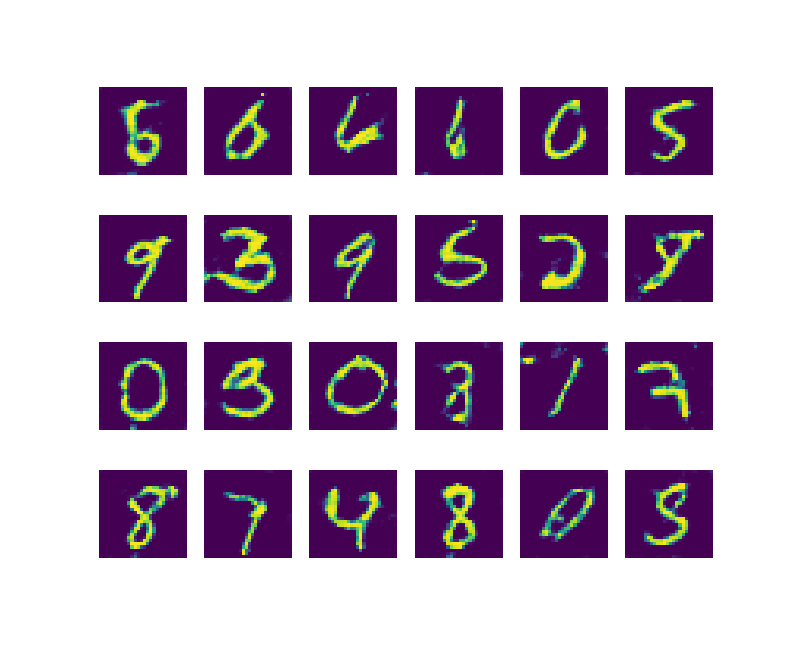

In [13]:
display_results()